In [2]:
import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Acknowledgement

Thanks to [J. Walton's post](https://jwalton.info/Embed-Publication-Matplotlib-Latex/)---instructions for pdf-perfect plots from matplotlib.

Thanks to Sihan for writing the code to plot the IGT data.

## Load the data

In [4]:
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
stability_data = load('data/stability-data.pkl')
xigt_data      = load('data/xigt-data-v2.pkl')

### Set the style and layout

In [5]:
def subplots(rows, cols, figsize,
#              titles=True, transpose_titles=False, x=0.12, y=0.65,
#              adjust=True, wspace=0.06, hspace=0.12,
             **kwargs):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, **kwargs)
#     if titles:
#         figures.title_subplots(axes.T if transpose_titles else axes, x=x, y=y)
#     if adjust:
#         plt.subplots_adjust(hspace=hspace, wspace=wspace)
    return fig, axes

In [6]:
C = plt.cm.gist_rainbow
C1 = C(0.6)
C2 = C(0.8)
CA = C(0.0)
CC = C(0.4)

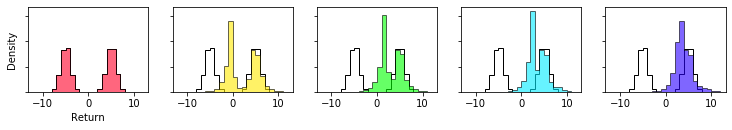

In [123]:
times = [0, 1, 2, 3, 4]
fig, axes = subplots(1, len(times), (2.5*len(times), 2.5/1.6), sharex=True, sharey=True)
bins = np.linspace(-12, 12, 25)
log = stability_data['direct imputer (half)']
for i, t in enumerate(times):
    color = C(t/len(times))
    axes[i].hist(log[0]['sample'], density=True, bins=bins,
                 histtype='step', color="black")
    axes[i].hist(log[t]['sample'], density=True, bins=bins, alpha=0.6,
                 histtype='stepfilled', color=color, edgecolor="black")
axes[0].set_yticklabels([])
axes[0].set_ylabel("Density")
axes[0].set_xlabel("Return")
plt.savefig("plots/imputation-divergence-first-4-iterations.png", bbox_inches="tight")
plt.show()

taus [0.1 0.3 0.5 0.7 0.9]
epss [-5.8234553  -2.98752436  0.03031826  3.02882374  5.83915773]


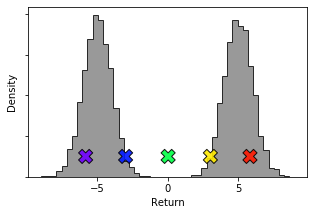

In [55]:
from util.expectiles import tauspace, expectile

fig, ax = subplots(1, 1, (5, 5/1.6))
bins = np.linspace(-9, 9, 50)
log = stability_data['direct imputer (half)']
sample = log[0]['sample']
epss = expectile(sample, [0.01, 0.2, 0.5, 0.8, 0.99])
print("taus", taus)
print("epss", epss)

ax.hist(sample, density=True, bins=bins, alpha=0.8,
        histtype='stepfilled', color="grey", edgecolor="black")
ax.scatter(epss, np.full_like(epss, 0.025), marker="X", alpha=0.9,
           s=200, c=C([0.85, 0.75, 0.45, 0.2, 0.05]), edgecolor="k",
           zorder=3)

ax.set_ylabel("Density")
ax.set_yticklabels([])
ax.set_xlabel("Return")
ax.set_xticks([-5, 0, 5])
plt.savefig("plots/expectiles-bimodal.png", bbox_inches="tight")
plt.show()

taus [0.5]
epss [0.03031826]


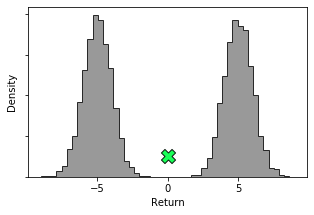

In [8]:
from util.expectiles import tauspace, expectile

fig, ax = subplots(1, 1, (5, 5/1.6))
bins = np.linspace(-9, 9, 50)
log = stability_data['direct imputer (half)']
sample = log[0]['sample']
epss = expectile(sample, [0.5])
print("taus", [0.5])
print("epss", epss)

ax.hist(sample, density=True, bins=bins, alpha=0.8,
        histtype='stepfilled', color="grey", edgecolor="black")
ax.scatter(epss, np.full_like(epss, 0.025), marker="X", alpha=0.9,
           s=200, c=C([0.45]), edgecolor="k",
           zorder=3)

ax.set_ylabel("Density")
ax.set_yticklabels([])
ax.set_xlabel("Return")
ax.set_xticks([-5, 0, 5])
plt.savefig("plots/expectiles-bimodal-traditional.png", bbox_inches="tight")
plt.show()

### Plot the igt data

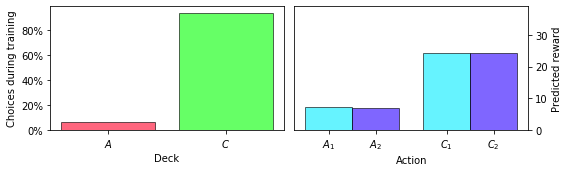

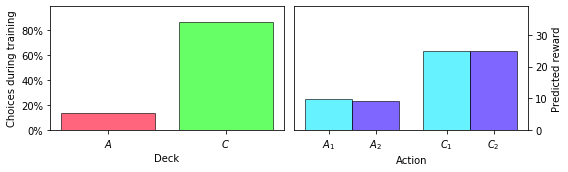

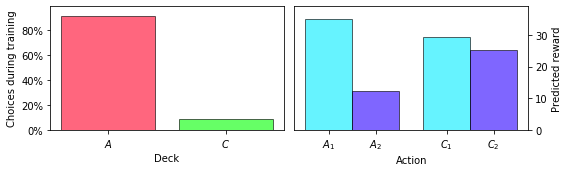

In [122]:
def plot_multi_bars(axis, heights, colors, transpose_colors=False):
    N, K = heights.shape
    # make plots
    # prepare offsets
    xs = np.arange(0, N)
    os,h = np.linspace(-.4, .4, K, endpoint=False, retstep=True)
    os += h/2
    # add bars
    for i, hs in enumerate(heights):
        c = colors[i] if transpose_colors else colors
        axis.bar(xs[i] + os, hs, h, color=c, alpha=0.6, edgecolor="black")
    axis.axhline(linewidth=1, color='black')

def plot(choices, predictions, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4/1.6))

    ax1.set_xlabel("Deck")
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['$A$', '$C$'])
    ax1.set_ylabel("Choices during training")
    ax1.set_ylim(0, 0.99)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))    
    # plot the action counts
    choices = np.array(choices)[[0, 2]] # just A and C
    choices = choices / choices.sum()
    plot_multi_bars(ax1, np.atleast_2d(choices).T, [CA, CC], transpose_colors=True)
    
    # plot the predictions
    ax2.set_xlabel("Action")
    ax2.set_xticks([-0.2, 0.2, 0.8, 1.2])
    ax2.set_xticklabels(['$A_1$', "$A_2$", '$C_1$', "$C_2$"])
    ax2.set_ylabel("Predicted reward")
    ax2.set_ylim(0, 39)
    ax2.set_yticks([0, 10, 20, 30])
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()   
    preds = np.array([[predictions['A1'], predictions['A2']],
                      [predictions['C1'], predictions['C2']],])
    plot_multi_bars(ax2, preds, [C1, C2])

    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

plot(xigt_data['traditional action counts'],   xigt_data['traditional'],
     "plots/igt-A-vs-C-traditional-model.png")
plot(xigt_data['direct action counts'],        xigt_data['direct'],
     "plots/igt-A-vs-C-full-distributional-model.png")
plot(xigt_data['direct (half) action counts'], xigt_data['direct (half)'],
    "plots/igt-A-vs-C-half-distributional-model.png")